# Image caption generator

### In this project weare going to use an pretrained model Xception and deep learning method to generate caption from images

# Import the libraries

In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm 
tqdm().pandas()
import  matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

# Importing the datasets


In [2]:
image_path = '../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset'
caption_path = '../input/flickr8k-imageswithcaptions/Flickr8k_text/Flickr8k.token.txt'

# defining some functions


### to perform some NLP task

In [3]:
def load_doc(path):
    file = open(path, 'r')
    text = file.read()
    file.close()
    return text


def all_img_captions(path):
    file =load_doc(path)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        image, caption = caption.split('\t')
        if image[:-2] not in descriptions:
            descriptions[image[:-2]] = [caption]
        else:
            descriptions[image[:-2]].append(caption)
    return descriptions


def clean_captions(captions):
    table = str.maketrans('','',string.punctuation)
    for img, caps in captions.items():
        for i , img_caption in enumerate(caps):
            img_caption.replace("-", " ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if (len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            img_caption = ' '.join(desc)
            captions[img][i] = img_caption
    return captions


def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


def save_descriptions(descriptions, path):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()

In [4]:
descriptions = all_img_captions(caption_path)
clean_descriptions = clean_captions(descriptions)
vocabulary = text_vocabulary(clean_descriptions)
print('length of vocabulary: ', len(vocabulary))
save_descriptions(clean_descriptions, 'descriptions.txt')

length of vocabulary:  8763


# extract features using Xception 

In [5]:
def extract_features(path):
    model = Xception(include_top = False, pooling = 'avg' )
    features = {}
    for img in tqdm(os.listdir(path)):
        filename = path + "/" + img
        image = Image.open(filename)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis = 0)
        image = image/127.5 
        image = image -1.0 
        feature = model.predict(image)
        features[img] = feature
        
    return features


features = extract_features(image_path)
dump(features, open("features.p","wb"))

2022-08-10 03:51:04.144227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 03:51:04.279104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 03:51:04.279845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 03:51:04.281353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/8091 [00:00<?, ?it/s]

2022-08-10 03:51:09.488000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-10 03:51:11.258837: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


# load our images and descriptions

In [6]:
def load_photos(path):
    file = load_doc(path)
    photos = file.split('\n')[:-1]
    return photos
def load_clean_descriptions(path, photos):
    file = load_doc(path)
    descriptions = {}
    for line in file.split('\n'):
        words = line.split()
        if len(words)<1:
            continue
        
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start>' + ' '.join(image_caption) + '<end>'
            descriptions[image].append(desc)
            
    return descriptions

def load_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features



        

In [7]:
train_image_path = '../input/flickr8k-imageswithcaptions/Flickr8k_text/Flickr_8k.trainImages.txt'

train_images = load_photos(train_image_path)
train_descriptions = load_clean_descriptions('descriptions.txt', train_images)
train_features = load_features(train_images)

# More NLP

In [8]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [9]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
print(max_length)

32


In [10]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

            
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

# Define our model

In [11]:
from tensorflow.keras.utils import plot_model

def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model
    

In [12]:
print('Dataset: ', len(train_images))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 5
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) +".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1939712     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]        

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6000/6000 [==============================] - 588s 98ms/step - loss: 3.0934


# define the captioning model

In [13]:
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :2]
    image = np.expand_dims(image, axis = 0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text




In [14]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_4.h5')
xception_model = Xception(include_top=False, pooling="avg")

path1 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/872622575_ba1d3632cc.jpg"
path2 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/2309860995_c2e2a0feeb.jpg"
path3 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/241347204_007d83e252.jpg"
path4 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/3502343542_f9b46688e5.jpg"
path5 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/757332692_6866ae545c.jpg"
path6 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/2748729903_3c7c920c4d.jpg"
path7 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/494792770_2c5f767ac0.jpg"
path8 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/3213992947_3f3f967a9f.jpg"
path9 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/2295750198_6d152d7ceb.jpg"
path10 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/2358898017_24496b80e8.jpg"
path11 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/3222055946_45f7293bb2.jpg"
path12 = "../input/flickr8k-imageswithcaptions/Flickr8k_Dataset/Flicker8k_Dataset/444481722_690d0cadcf.jpg"


# Let's predict the caption of images 



start man in red shirt is climbing up rock face end


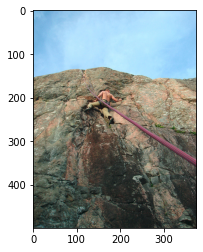

In [15]:
img = Image.open(path1)
photo = extract_features(path1, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)
    



start man in black shirt is sitting on bench end


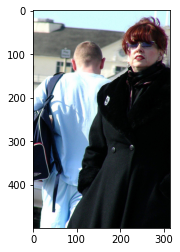

In [16]:
img = Image.open(path2)
photo = extract_features(path2, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start baseball player in red and white uniform is playing hockey end


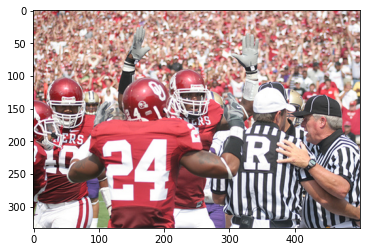

In [17]:
img = Image.open(path3)
photo = extract_features(path3, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start man in red shirt is climbing up rock end


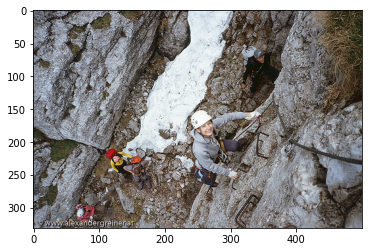

In [18]:
img = Image.open(path4)
photo = extract_features(path4, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start the dog is running through the grass end


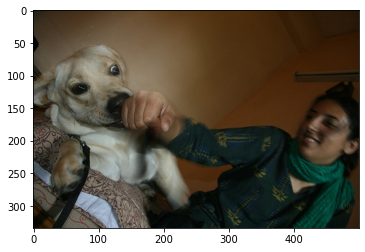

In [19]:
img = Image.open(path5)
photo = extract_features(path5, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start two children are playing in the water end


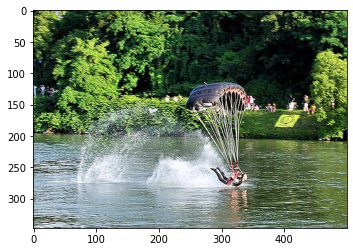

In [20]:
img = Image.open(path6)
photo = extract_features(path6, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start dog is running through the grass end


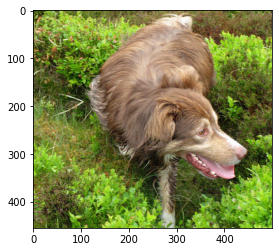

In [21]:
img = Image.open(path7)
photo = extract_features(path7, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start woman and child are sitting on the edge of the water end


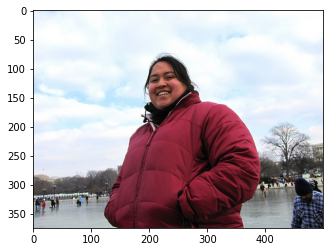

In [22]:
img = Image.open(path8)
photo = extract_features(path8, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start two children are playing with toy in the grass end


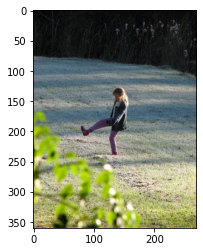

In [23]:
img = Image.open(path9)
photo = extract_features(path9, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start two dogs play with ball end


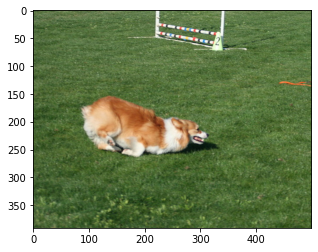

In [24]:
img = Image.open(path10)
photo = extract_features(path10, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start the basketball player in the white shirt is playing with the ball end


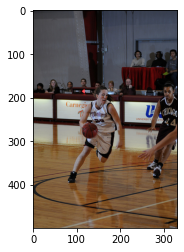

In [25]:
img = Image.open(path11)
photo = extract_features(path11, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)



start man in black shirt is sitting on bench end


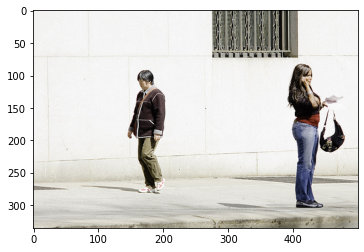

In [26]:
img = Image.open(path12)
photo = extract_features(path12, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print('\n')
print(description)
plt.imshow(img)

### Thanks for visiting